## Consistent cartographic projections across multiple recordings

In notebooks 1 and 2 we saw how to do tissue cartography on a single volumetric image. But often, we have multiple images of very similarly shaped objects - either the successive frames of a movie, or multiple recordings of biological structures with very consistent shape, like the _Drosophila_ egg. We want to use "the same" UV map/cartographic projection for all of the images - both so that we don't need to redo the work of creating the UV map, and so that positions in our cartographic projections always correspond to the same anatomical position on the imaged object (e.g. the anterior side of the _Drosophila_ embryo is always left, and the dorsal midline corresponds to the line $v=1/2$ in UV space).

To do this, we use _mesh registration_ and _mesh shrink-wrapping_. The idea is that we have a _reference mesh_ - for example, from the first frame of a movie - on which a UV map is defined. We then move and deform this mesh so that it fits our _target mesh_ - which describes the surface we want to extract from the volumetric data, for example in subsequent frames - as well as possible. The deformed reference mesh now fits the volumetric data but still carries the UV map, and can now be used to create a cartographic projection.

If you have a consistently-shaped object that you know you will image many times - in the Streichan lab, the early _Drosophila_ embryo, of which we have [hundreds of _in toto_ recordings](https://doi.org/10.25349/D9WW43) - it might make sense to make an idealized "prototypical" mesh with a nice mesh and UV map, that you can use as a reference.

Mesh/point cloud registration and deformation are very well studied problems and we can make use of many robust and already-implemented algorithms. We proceed in two steps:
1. Registration: Align reference mesh to target mesh using translations, rotations, and possible rescaling
2. Shrink-wrapping: Move each point on the registered reference mesh to the closest point on the surface defined by the target mesh.

For step 1, we provide some simple python code. We could also use the `pymeshlab` GUI. 
For step 2, we can use the [shrinkwrap modifier](https://docs.blender.org/manual/en/latest/modeling/modifiers/deform/shrinkwrap.html) in blender.

**Work in progress:** Automate step 2, the shrink-wrapping.

In [1]:
from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import interpolation as tcinterp
from blender_tissue_cartography import registration as tcreg

In [2]:
import numpy as np
from skimage import transform
from scipy import stats, spatial, linalg
import os
import matplotlib.pyplot as plt
import mcubes

In [3]:
import pymeshlab

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/envs/blender-tissue-cartography/lib/python3.11/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



In [4]:
np.set_printoptions(suppress=True)

## Loading and segmenting the dataset

We will use the same dataset - a _Drosophila_ example - as in notebook 2.

In [5]:
metadata_dict = {'filename': 'wrapping_example/Drosophila_CAAX-mCherry',
                 'resolution_in_microns': (1.05, 1.05, 1.05), # lightsheet data has isotropic resolution
                 'subsampling_factors': (1/2, 1/2, 1/2),
                }

In [6]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (1, 190, 509, 188)


In [7]:
subsampled_image = transform.rescale(image, metadata_dict['subsampling_factors'],
                                     channel_axis=0, preserve_range=True)
print("subsampled image shape:", subsampled_image.shape)

subsampled image shape: (1, 95, 254, 94)


## Create 3d segmentation

Now create a 3d segmentation, in this case using ilatik. We use [ilastik binary pixel classification](https://www.ilastik.org/documentation/pixelclassification/pixelclassification). We could post-process the ilastik output here, for example using morphsnakes. We then load the segmentation back into the jupyter notebook.

The bright dots outside the embryo are fluorescent beads necessary for sample registration in lightsheet microscopy. You can ignore them.

Attention: when importing the `.h5` into ilastik, make sure the dimension order is correct! In this case, `czyx` for both export and import.

In [8]:
# we now save the subsampled image a .h5 file for input into ilastik for segmentation

tcio.write_h5(f"{metadata_dict['filename']}_subsampled.h5", subsampled_image)

In [9]:
# after creating an ilastik project, training the model, and exporting the probabilities, we load the segmentation

segmentation = tcio.read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # select the first channel of the segmentation - it's the probablity a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (95, 254, 94)


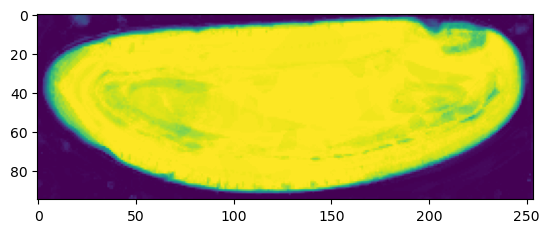

In [10]:
# look at the segmentation in a cross section

plt.imshow(segmentation[:,:,50], vmin=0, vmax=1)

## Meshing

We convert the segmentation into a triangular mesh using the marching cubes method, and save the mesh. We save all meshes in as wavefront `.obj` files (see [wikipedia](https://en.wikipedia.org/wiki/Wavefront_.obj_file)). In python, we represent missing entries (such as a vertex which doesn't have a normal by `np.nan`.

**Important convention** For sanities sake, we will always store all mesh coordinates in microns. This means rescaling appropriately after calculating the mesh from the 3d segmentation.

In [11]:
# now we create a 3d mesh of using the marching cubes method

level_set = mcubes.smooth(segmentation, method="gaussian", sigma=2)
# converts segmentation into level set, with 0=surface
vertices, faces = mcubes.marching_cubes(level_set, 0)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

In [12]:
mesh = tcio.ObjMesh(vertices_in_microns, faces)
mesh.name = "Drosophila_CAAX-mCherry_mesh_marching_cubes"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

In [13]:
# improve mesh quality using meshlab - optional
ms = pymeshlab.MeshSet()
ms.load_new_mesh(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")
ms.meshing_isotropic_explicit_remeshing()
ms.save_current_mesh(f"{metadata_dict['filename']}_mesh_remeshed.obj")

## Registration

In the data folder, we have the mesh we just created, `Drosophila_CAAX-mCherry_mesh_remeshed.obj`, as well as out **reference mesh**  `Drosophila_reference.obj` - an idealized _Drosophila_ embryo with a standardized UV mapping, corresponding to a cylindrical projection. You can look at both meshes in the blender file `Drosophila_CAAX-mCherry.blend`.

We now register the reference mesh, i.e. bring it into approximate alignment with the data mesh. This is done in two steps (using a first, coarse alignment, and refining it using the [Iterative Closest Point algorithm](https://en.wikipedia.org/wiki/Iterative_closest_point)).

In [14]:
mesh_data = tcio.ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")
mesh_ref = tcio.ObjMesh.read_obj(f"wrapping_example/Drosophila_reference.obj")

In [15]:
trafo_initial, _ = tcreg.align_by_centroid_and_intertia(mesh_ref.vertices,
                                                        mesh_data.vertices,
                                                        scale=True, shear=True)

In [16]:
trafo_icp, _, _ = tcreg.icp(mesh_ref.vertices, mesh_data.vertices,
                            initial=trafo_initial, threshold=1e-4, max_iterations=100,
                            scale=True, n_samples=5000)

In [17]:
# apply the computed transformation and save the result
mesh_registered = mesh_ref.apply_affine_to_mesh(trafo_icp)
mesh_registered.name = "Drosophila_reference_preregistered"
mesh_registered.write_obj(f"wrapping_example/Drosophila_reference_registered.obj")

### Registration in MeshLab

You can also perform registration graphically in MeshLab - see this tutorial: https://www.youtube.com/watch?v=30bJcj6yA4c. Use this if you have problems with the automated method above.

## Wrapping

Now that we have registered the mesh, we can wrap it! Let's first do it using blender with the [shrinkwrap modifier](https://docs.blender.org/manual/en/latest/modeling/modifiers/deform/shrinkwrap.html). Go to the "layout" tab and click the "blue wrench" on the right to add a modifier. Search for shrinkwrap, select the target, and use "Tangent Normal Project" for best results:

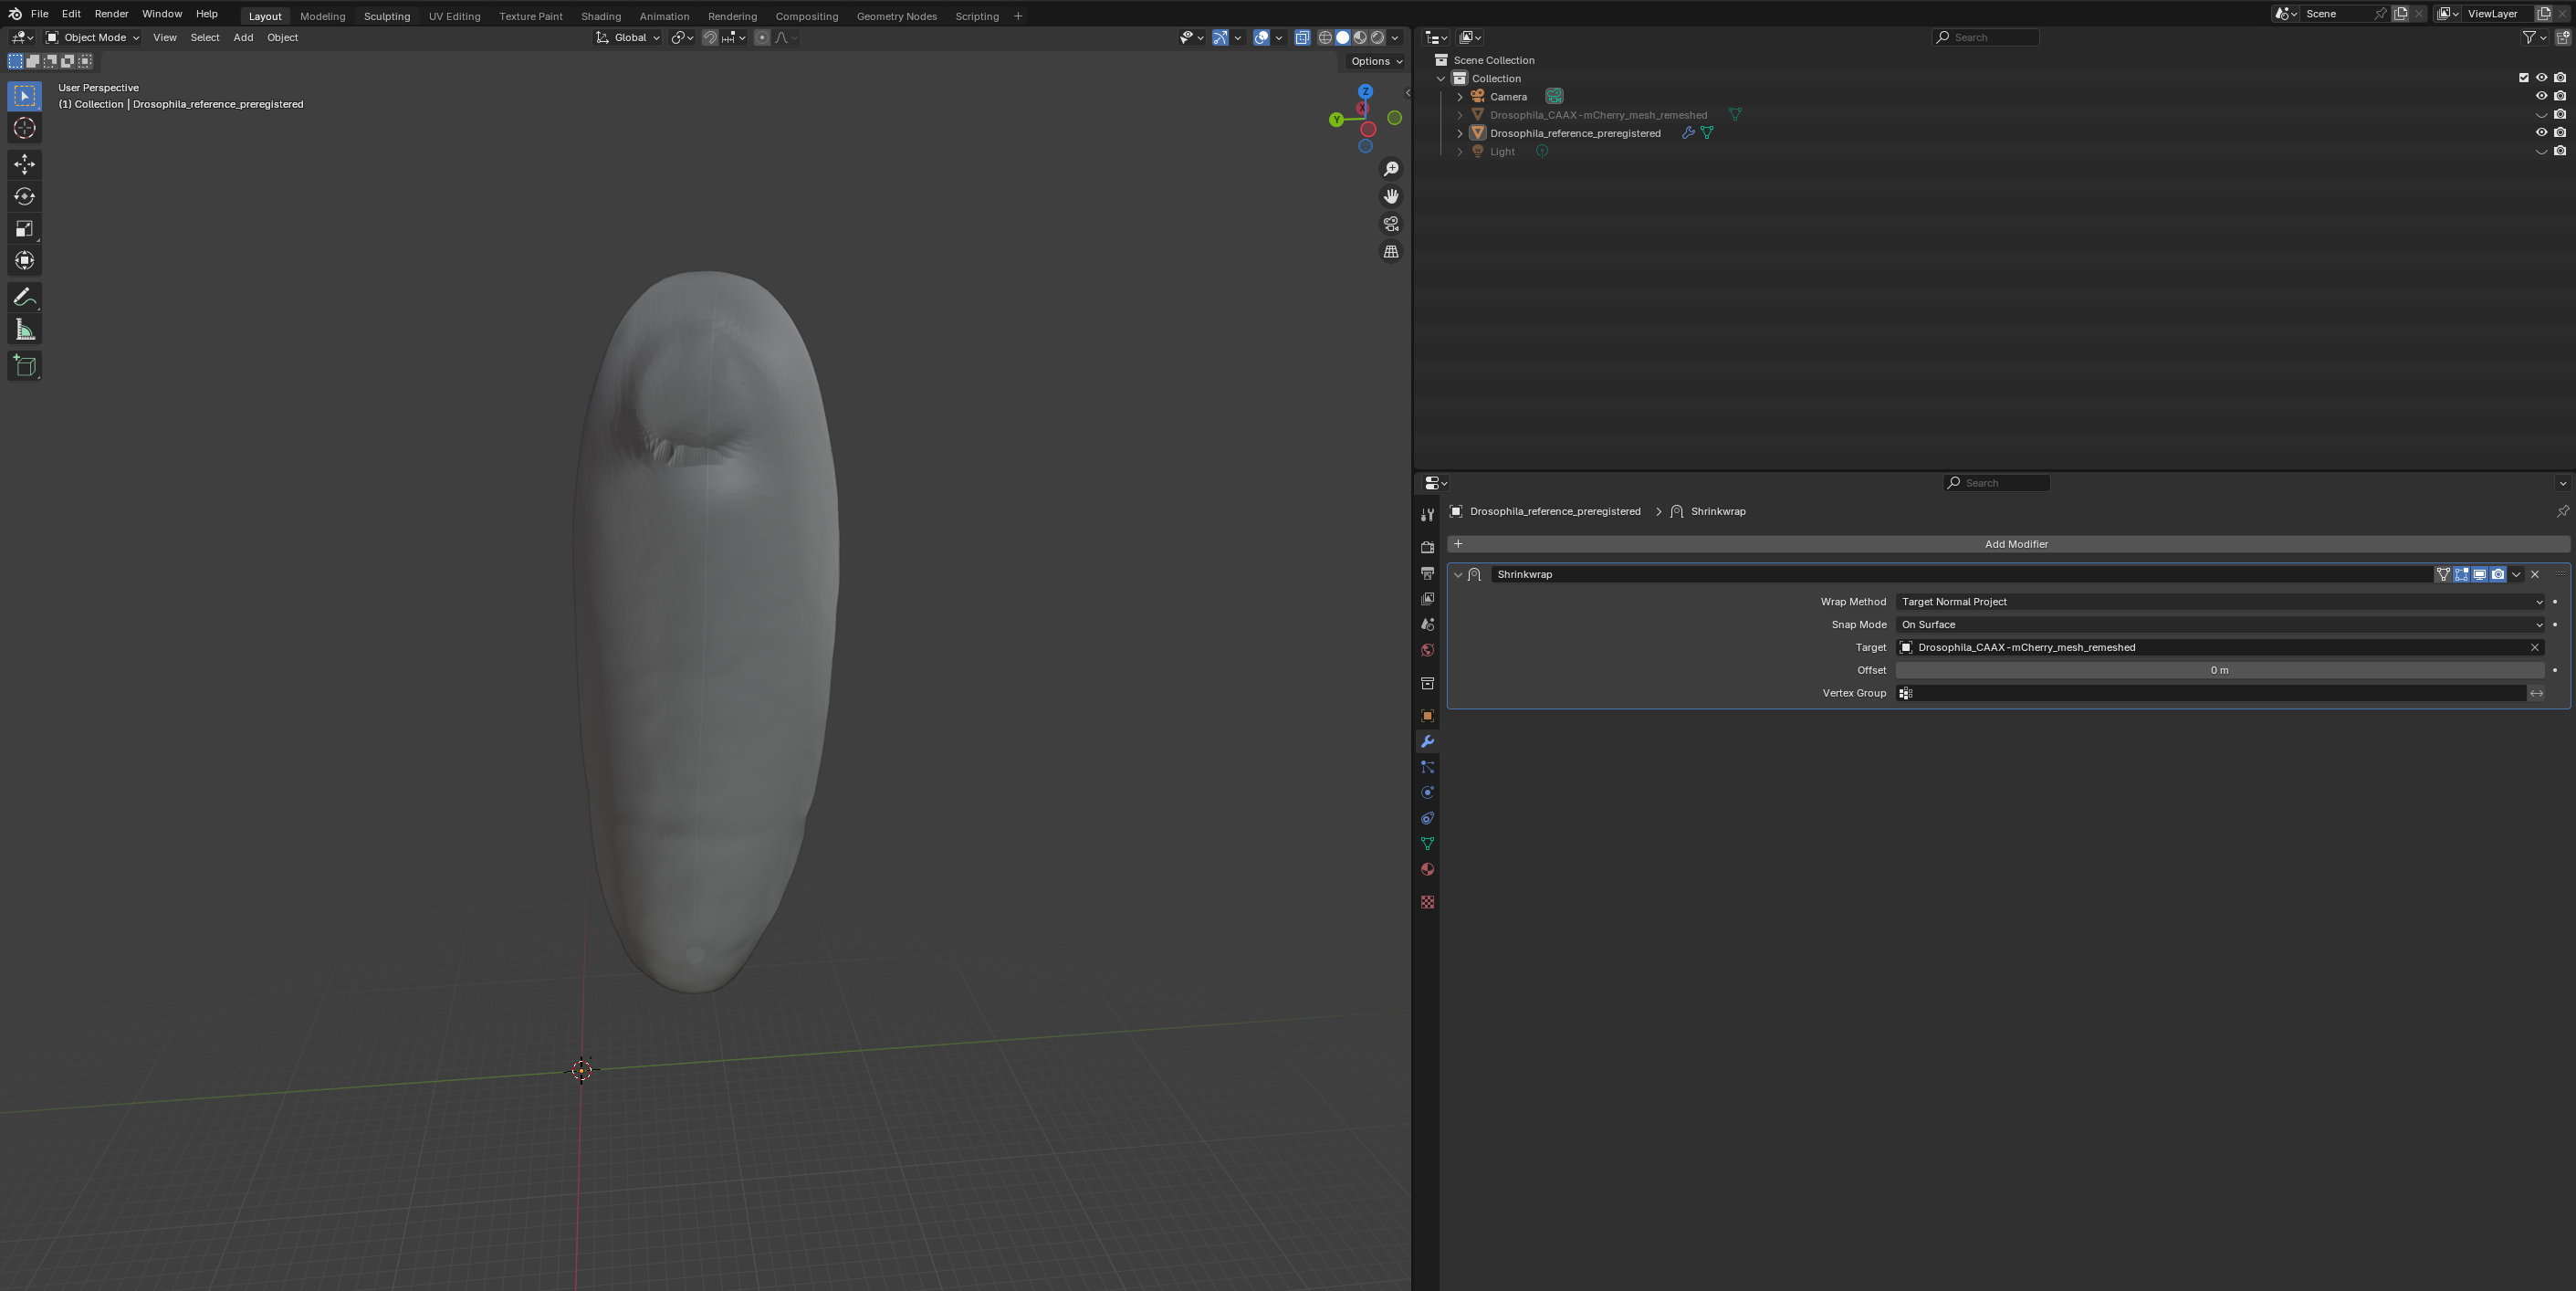

If things look good, click "Apply" to make the modifier permanent and export the mesh as `Drosophila_reference_wrapped.obj`.

### Normals and normal-related problems

This may be a good point to note that if you have any problems with multilayer projections, your normals may be messed up. [Some advice](https://all3dp.com/2/blender-recalculate-normals-simply-explained/) on how to visualize and if necessary, recalculate mesh normals.

**Useful tools**: "Recalculate normals" (under "Mesh" in "Edit Mode"), and the modifier "Normals -> Weighted Normal" (smoothes normals) and "Deform -> Smooth".

In [21]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
#mesh = tcio.ObjMesh.read_obj(f"wrapping_example/Drosophila_reference_wrapped.obj")
mesh = tcio.ObjMesh.read_obj(f"wrapping_example/Drosophila_CAAX-mCherry_mesh_remeshed_sphere_uv.obj")

resolution = metadata_dict["resolution_in_microns"]

In [22]:
slice_image, slice_vertices, slice_normals = tcinterp.get_cross_section_vertices_normals(
    1, 100, image, mesh, metadata_dict["resolution_in_microns"], width=1.5)

In [27]:
slice_axis, slice_index = (1, 100)
width = 1.5

In [28]:
slice_image = image.take(indices=slice_index, axis=slice_axis+1).transpose((0,2,1))
slice_coordinate = slice_index*resolution[slice_axis]

mesh.match_vertex_info()
slice_mask = np.abs(mesh.matched_vertices[:,slice_axis]-slice_coordinate) < width
slice_vertices = mesh.matched_vertices[slice_mask] / resolution
slice_vertices = slice_vertices.take(indices=[i for i in range(3) if i != slice_axis], axis=1)
slice_normals = mesh.matched_normals[slice_mask] / resolution
slice_normals = slice_normals.take(indices=[i for i in range(3) if i != slice_axis], axis=1)

In [29]:
mesh.matched_vertices.shape

(8532, 3)

In [30]:
mesh.vertices.shape

(8425, 3)

In [24]:
slice_normals

array([[-0.85685714, -0.40447619],
       [-0.82742857,  0.4652381 ],
       [-0.87352381,  0.3552381 ],
       [-0.84247619, -0.43619048],
       [-0.83209524, -0.45361905],
       [-0.82752381,  0.46333333],
       [-0.85447619,  0.41361905],
       [-0.87104762, -0.3572381 ],
       [-0.87942857, -0.36352381],
       [-0.75314286,  0.58161905],
       [-0.80952381, -0.48047619],
       [-0.86095238, -0.40419048],
       [-0.76028571, -0.56828571],
       [-0.82419048, -0.43914286],
       [-0.76419048,  0.54495238],
       [-0.75685714,  0.55809524],
       [-0.72514286,  0.60142857],
       [-0.63019048, -0.71390476],
       [-0.69095238,  0.6552381 ],
       [-0.59152381, -0.29552381],
       [-0.66285714,  0.68352381],
       [-0.66285714,  0.68361905],
       [-0.64485714,  0.69780952],
       [-0.55257143,  0.75066667],
       [-0.57895238, -0.7532381 ],
       [-0.58666667, -0.75009524],
       [-0.45333333,  0.70371429],
       [-0.54790476,  0.77742857],
       [-0.41419048,

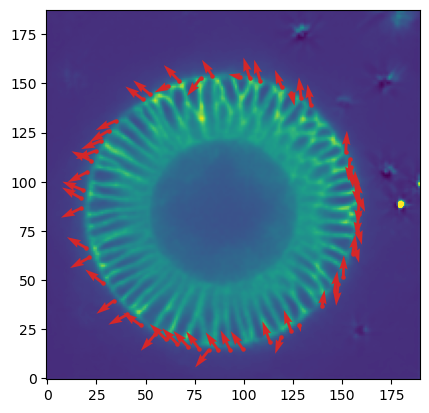

In [23]:
plt.scatter(*slice_vertices.T, s=5, c="tab:red")
plt.quiver(*slice_vertices.T, *slice_normals.T, color="tab:red")

plt.imshow(slice_image[0], vmax=10000, origin="lower")

## UV projection

To see how well all of this has worked, let's use the wrapped mesh to generate UV projections. We will compare it with the automatic sphere unwrap on the original data mesh.

In [28]:
normal_offsets = np.array([-4, -2, 0, 2])
metadata_dict["normal_offsets"] = normal_offsets # add the info to the metadata
uv_grid_steps = 512

In [29]:
tcio.save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

In [32]:
projected_data_wrapped, projected_coordinates_wrapped, projected_normals_wrapped = tcinterp.create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh=f"wrapping_example/Drosophila_reference_wrapped.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)

In [33]:
projected_data, projected_coordinates, projected_normals = tcinterp.create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh="wrapping_example/Drosophila_CAAX-mCherry_mesh_remeshed_sphere_uv.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)

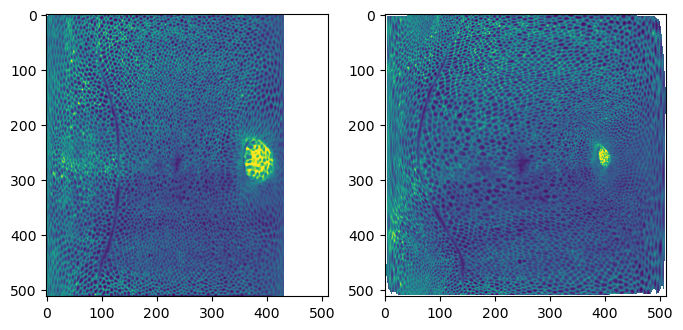

In [35]:
# show the projected data

fig, (ax1, ax2) = plt.subplots(figsize=(8,8), ncols=2)
ax1.imshow(projected_data_wrapped[0, 0], vmax=10000)
ax2.imshow(projected_data[0, 0][::-1,::-1].T, vmax=10000)

In [36]:
# save images for visualization in blender
texture_path = f"{os.getcwd()}/{metadata_dict['filename']}_textures"
tcio.save_stack_for_blender(projected_data_wrapped, texture_path, normalization=(0.01, 0.99))

In [37]:
# save images as .tif stack for analysis
tcio.save_for_imageJ(f"{metadata_dict['filename']}_projected.tif", projected_data_wrapped, z_axis=1)
tcio.save_for_imageJ(f"{metadata_dict['filename']}_3d_coordinates.tif", projected_coordinates_wrapped)
tcio.save_for_imageJ(f"{metadata_dict['filename']}_normals.tif", projected_normals_wrapped)

Let's add a shader to check the texture looks good:

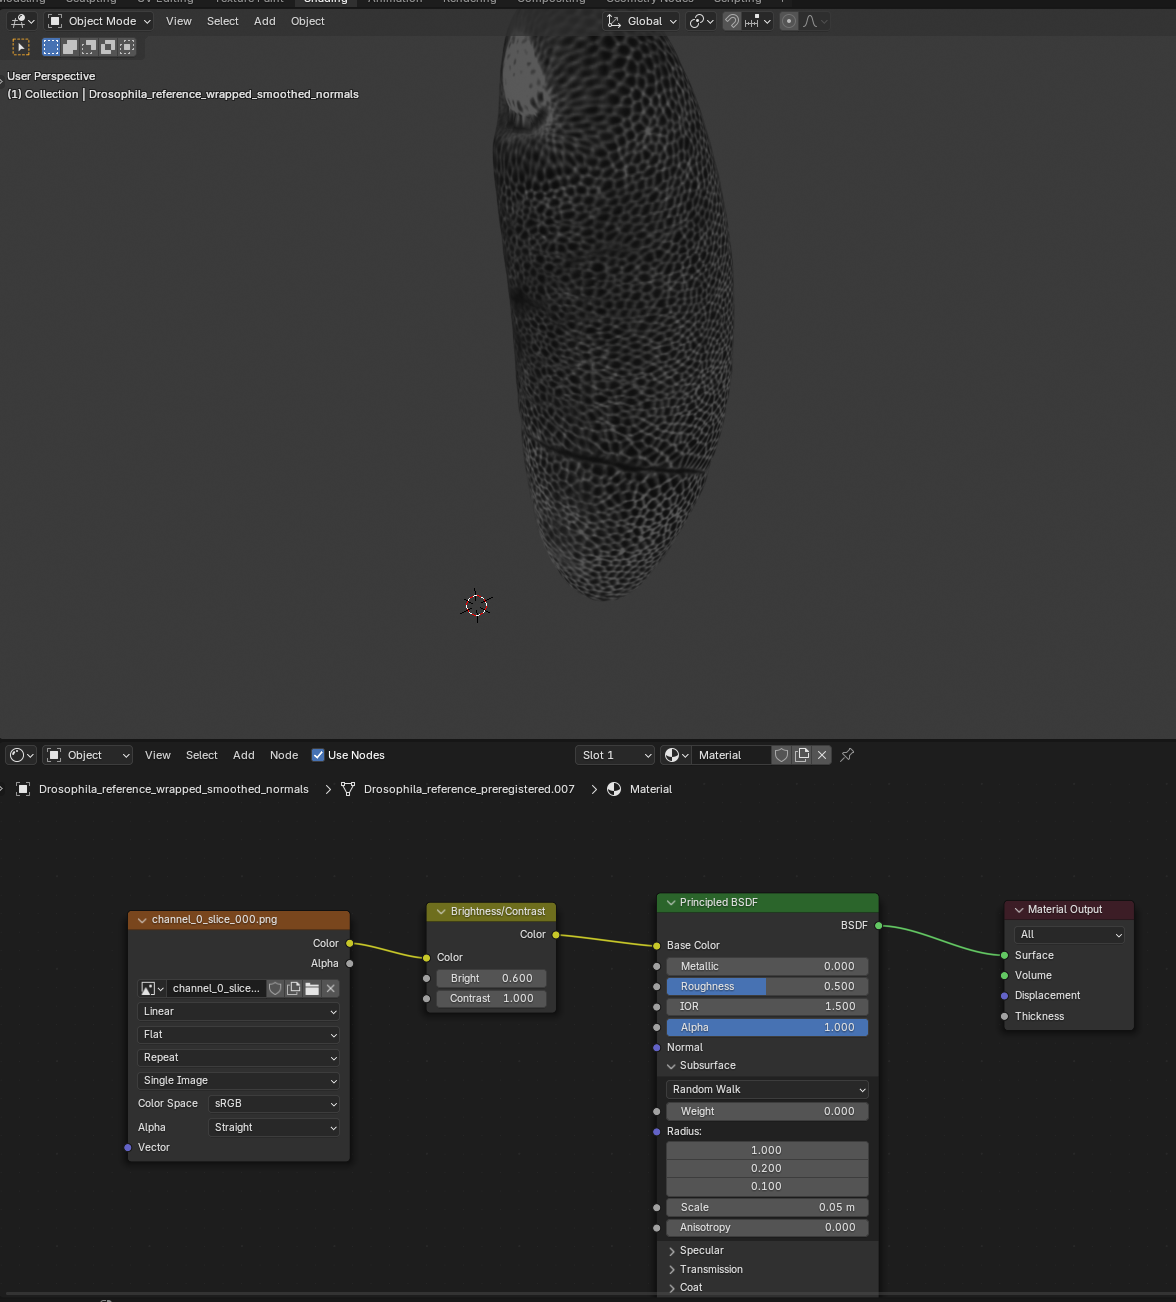


## Automated shrink-wrapping

Of course, we don't want to click through $\sim100$ frames of a movie to shrink-wrap manually each time. Automated tools coming soon!